In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
###Read data
df = pd.read_excel('/content/drive/MyDrive/DSEB_61/Online Retail (2).xlsx')

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [181]:
df.shape

(541909, 8)

PART I: DATA CLEANING AND KPIs

1. Data Cleaning (1 point)
- Drop duplicated rows
- Delete records with the value of Quantity <= 0
- Filter out incomplete data for December 2011
- Drop records with null CustomerID

In [182]:
df.drop_duplicates()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [183]:
df = df[~(df.Quantity<=0)]

In [184]:
df.shape

(531285, 8)

In [185]:
df['order_year_month'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [186]:
df = df[~(df.order_year_month == '2011-12')]

In [187]:
df = df[df["CustomerID"].notnull()]

In [188]:
df.shape

(380620, 9)

2. Calculate and Visualize the numbers of orders received per month(2 point)

In [189]:
##Create new column named year-month to extract year and month from InvoiceDate column using strftime
##your code here###

In [190]:
##Groupby year-month column and count the number of unique InvoiceNo for each month and visualize it
grouped_df = df.groupby(['order_year_month', 'CustomerID'])['InvoiceNo'].nunique().reset_index()

In [191]:
grouped_df

,order_year_month,CustomerID,InvoiceNo
0,2010-12,12347.0,1
1,2010-12,12348.0,1
2,2010-12,12370.0,2
3,2010-12,12377.0,1
4,2010-12,12383.0,1
...,...,...,...
12435,2011-11,18259.0,1
12436,2011-11,18263.0,1
12437,2011-11,18270.0,1
12438,2011-11,18274.0,1


In [192]:
grouped_df = grouped_df[grouped_df['InvoiceNo'] > 1]

In [193]:
monthly_cust = grouped_df.groupby('order_year_month').CustomerID.count().reset_index()

In [194]:
monthly_cust

,order_year_month,CustomerID
0,2010-12,263
1,2011-01,149
2,2011-02,150
3,2011-03,201
4,2011-04,168
5,2011-05,279
6,2011-06,219
7,2011-07,227
8,2011-08,196
9,2011-09,271


No handles with labels found to put in legend.


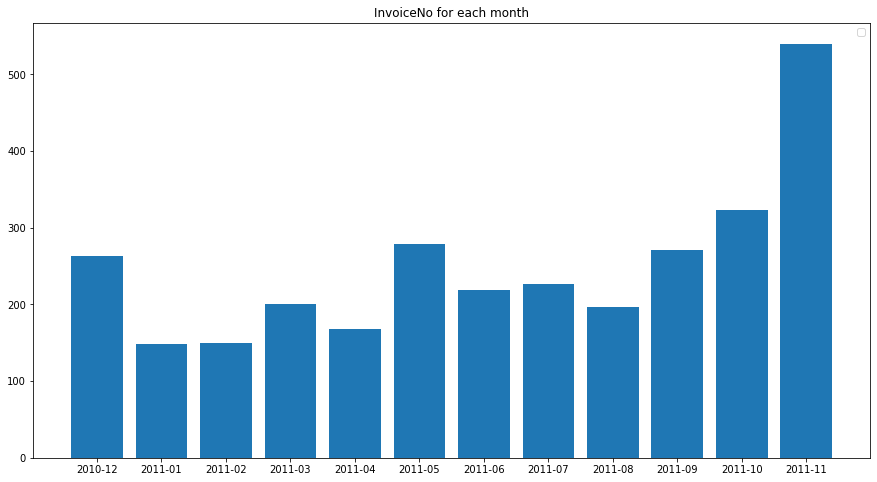

In [195]:
plt.figure(figsize=(15,8))
plt.bar(monthly_cust.order_year_month, monthly_cust.CustomerID)
plt.title("InvoiceNo for each month")
plt.legend()

PART II: Customer Segmentation and CLV

RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments.
   It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy.
   In this section we will practice implementing the customer segment based on the RFM model

1. Calculate Recency, Frequency, Monetary values for each customer. Store the result in a dataframe named the customer_df(4 points)
- Frequency is the number of orders made by a customer. 
- Recency is the number of days counting from the last date a customer making an order to the last date in the analysis cycle.
For example if the last date in the analysis cycle is 30/11/2011, the last date a customer making an order is 25/11/2011. As a result, recency value is 5.
- Monetary is the total amount of money the customer has purchased during the analysis cycle(1 point).

In [196]:
##Create a new dataframe named cusomter_df with only a column 'CustomerID'. Each row contains the ID of a CustomerID 
customer_df = pd.DataFrame()
customer_df['CustomerID'] = df['CustomerID']

In [197]:
##Create new column named ‘TotalRevenue’ as product of two columns Quantity and  UnitPrice
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [198]:
frequency_df = frequency_df = df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
customer_df  = pd.merge(customer_df,frequency_df,how='inner', on='CustomerID')
'''monetary_df = ##your code here##
monetary_df.columns = ##your code here###
customer_df = ##your code here##
recency_df = ##your code here##
recency_df.columns = ##your code here##
customer_df = ##your code here##'''

'monetary_df = ##your code here##\nmonetary_df.columns = ##your code here###\ncustomer_df = ##your code here##\nrecency_df = ##your code here##\nrecency_df.columns = ##your code here##\ncustomer_df = ##your code here##'

In [199]:
customer_df = customer_df.drop_duplicates()

In [200]:
#last date available in our dataset
df['InvoiceDate'].max()

Timestamp('2011-11-30 17:37:00')

In [201]:
import datetime as dt

In [202]:
now = dt.date(2011,11,30)

In [203]:
customer_df['date'] = df['InvoiceDate'].dt.date

In [204]:
recency_df = customer_df.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-05-13
1,12347.0,2011-02-15
2,12348.0,2011-04-10
3,12349.0,NaN
4,12350.0,NaN


In [205]:
recency_df = recency_df[recency_df["LastPurshaceDate"].notnull()]

In [206]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [207]:
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

In [208]:
recency_df.head()

,CustomerID,Recency
0,12346.0,201
1,12347.0,288
2,12348.0,234
5,12352.0,170
6,12353.0,107


In [209]:
customer_df  = pd.merge(customer_df,recency_df,how='inner', on='CustomerID')

In [210]:
customer_df['TotalCost'] = df['Quantity'] * df['UnitPrice']

In [211]:
monetary_df = customer_df.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,4.25
1,12347.0,30.00
2,12348.0,9.90
3,12352.0,15.60
4,12353.0,0.00


In [212]:
customer_df  = pd.merge(customer_df,monetary_df,how='inner', on='CustomerID')

In [213]:
customer_df.head()

,CustomerID,Frequency,date,Recency,TotalCost,Monetary
0,17850.0,297,2010-12-01,364,15.30,15.30
1,13047.0,172,2010-12-01,364,20.34,20.34
2,12583.0,228,2010-12-01,364,22.00,22.00
3,13748.0,28,2010-12-01,364,20.34,20.34
4,15100.0,3,2010-12-01,364,20.34,20.34


2. Add segment bin values to RFM table using quartile. For example, If the recency value belongs to the first quartile, the recency value will be replaced by 1, if it belongs to the second quartile, that value will be replaced by 2...(3 point) 
- Hint: using pd.qcut, create new columns named r_quantile, f_quantile and m_quantile in the dataframe customer_df 

In [214]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,201,1
1,12347.0,288,171
2,12348.0,234,31
3,12352.0,170,85
4,12353.0,107,4


In [215]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,201,1,4.25
12347.0,288,171,30.00
12348.0,234,31,9.90
12352.0,170,85,15.60
12353.0,107,4,0.00


In [216]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,80.0,16.0,0.0
0.50,128.0,40.0,3.3
0.75,199.0,96.0,15.0


In [217]:
quantiles.to_dict()

{'Frequency': {0.25: 16.0, 0.5: 40.0, 0.75: 96.0},
 'Monetary': {0.25: 0.0, 0.5: 3.3, 0.75: 15.0},
 'Recency': {0.25: 80.0, 0.5: 128.0, 0.75: 199.0}}

In [218]:
def Recency_(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
def Frequency_Monetary(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [219]:
customer_df['r_quantile'] = customer_df['Recency'].apply(Recency_, args=('Recency',quantiles,))
customer_df['f_quantile'] = customer_df['Frequency'].apply(Frequency_Monetary, args=('Frequency',quantiles,))
customer_df['m_quantile'] = customer_df['Monetary'].apply(Frequency_Monetary, args=('Monetary',quantiles,))

3. In the customer_df, Create a new column named RFM_Score(1 point). The formula for RFM_Score is as follow
             RFM_Score = r_quantile + f_quantile + m_quantile

In [220]:
customer_df['RFM_Score'] = customer_df.r_quantile + customer_df.f_quantile + customer_df.m_quantile
customer_df.head()

,CustomerID,Frequency,date,Recency,TotalCost,Monetary,r_quantile,f_quantile,m_quantile,RFM_Score
0,17850.0,297,2010-12-01,364,15.30,15.30,1,4,4,9
1,13047.0,172,2010-12-01,364,20.34,20.34,1,4,4,9
2,12583.0,228,2010-12-01,364,22.00,22.00,1,4,4,9
3,13748.0,28,2010-12-01,364,20.34,20.34,1,2,4,7
4,15100.0,3,2010-12-01,364,20.34,20.34,1,1,4,6


4. Based on RFM_Score, customers are divided into 3 segments: low-value, mid-value and high value so that it is satisfy the following rules (2 points):
 - The number of customers of high value segment does not exceed 20% of the total number of customers.
 - The number of customers of mid value segment is no less than 30% of the total number of customers.

In [221]:
customer_df.shape[0]/100*20

634.6

In [222]:
customer_df.shape[0]/100*30+859

1810.9

In [223]:
v1 = customer_df.sort_values(by='RFM_Score', ascending=False ).reset_index().RFM_Score[859]
v2 =customer_df.sort_values(by='RFM_Score', ascending=False ).reset_index().RFM_Score[2148]

In [224]:
def RFM(x):
  if x > v1:
    return 3
  elif x > v2:
    return 2
  else:
    return 1

In [225]:
customer_df['RMF_quantile'] = customer_df.RFM_Score.apply(RFM)

In [226]:
customer_df[customer_df.RFM_Score > 13]

,CustomerID,Frequency,date,Recency,TotalCost,Monetary,r_quantile,f_quantile,m_quantile,RFM_Score,RMF_quantile


In [227]:
customer_df[(customer_df.RFM_Score < 14) & (customer_df.RFM_Score > 9)]

,CustomerID,Frequency,date,Recency,TotalCost,Monetary,r_quantile,f_quantile,m_quantile,RFM_Score,RMF_quantile
866,13168.0,131,2011-05-22,192,25.50,25.50,2,4,4,10,3
873,16133.0,288,2011-05-22,192,20.00,20.00,2,4,4,10,3
878,14049.0,488,2011-05-22,192,25.20,25.20,2,4,4,10,3
931,15144.0,196,2011-05-29,185,35.70,35.70,2,4,4,10,3
932,14776.0,117,2011-05-29,185,27.04,27.04,2,4,4,10,3
...,...,...,...,...,...,...,...,...,...,...,...
3165,15790.0,35,2011-10-06,55,17.70,17.70,4,2,4,10,3
3166,13521.0,126,2011-10-06,55,17.70,17.70,4,4,4,12,3
3167,14349.0,31,2011-10-06,55,17.70,17.70,4,2,4,10,3
3169,12953.0,17,2011-10-06,55,17.40,17.40,4,2,4,10,3


# CLV = (Average Sales x Purchase Frequency) / Churn) x Profit Margin
Where:
- Average Sales = (TotalRevenue) / Total no.of orders
- Purchase Frequency = (Total no.of orders) / (Total unique customers)
- Retention rate = (Total no. of orders greater than 1) / Total unique customers
- Churn rate = 1 – Retention rate
- Profit Margin = Based on business contex
- We assume that the Profit Margin = 0.05
5. Question: Calculate CLV for each customer group?(2 points)

In [228]:
average_sales = df.TotalRevenue.mean()
purchase_frequency = customer_df.Frequency.sum()/customer_df.shape[0]
retention_rate = customer_df[customer_df.Frequency > 1].shape[0]/customer_df.shape[0]
churn_rate = 1 - retention_rate

In [229]:
print('Average Sale:',average_sales)
print('Purchase Frequency:',purchase_frequency)
print('Retention Rate:',retention_rate)
print('Churn rate:',churn_rate)

Average Sale: 22.05142954653923
Purchase Frequency: 86.96753860699653
Retention Rate: 0.9820359281437125
Churn rate: 0.017964071856287456


# PART III: BUILD A RECOMMENDATION SYSTEM

1.Build a customer-item matrix:The customer-item matrix is simply tabular data, where
each column represents each product or item, each row represents a
customer, and the value in each cell represents whether the given customer
purchased the given product or not (2 point)

In [230]:
from mlxtend.frequent_patterns import apriori, association_rules

In [231]:
df_basket = df.groupby(["InvoiceNo","StockCode"]).size().reset_index(name="Count")

cus_matrix = (df_basket.groupby(['InvoiceNo', 'StockCode'])['Count'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
cus_matrix

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
579872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. Build item-item-similarity matrix using cosine_similarity function. That matrix stores cosine similarities between items(1 point)

In [232]:
##In order to import cosine_similarity function via scikit-learn package, You need just uncomment the following code
from sklearn.metrics.pairwise import cosine_similarity

In [233]:
item_item_sim_matrix = pd.DataFrame(cosine_similarity((cus_matrix.T)))

3.Rename the index and columns of the item-item-similarity matrix using the name of products(StockCode)(1 point)

In [234]:
item_item_sim_matrix.columns = cus_matrix.T.index
item_item_sim_matrix['StockCode'] = cus_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')


In [235]:
item_item_sim_matrix

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.00000,0.051316,0.034648,0.012627,0.038487,0.017719,0.000000,0.029951,0.023773,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.030861
10080,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045751,0.012105,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011050,0.0,0.000000
10120,0.051316,0.00000,1.000000,0.043561,0.031750,0.032258,0.022277,0.000000,0.075311,0.009963,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.009095,0.0,0.000000
10125,0.034648,0.00000,0.043561,1.000000,0.032156,0.010890,0.015041,0.000000,0.000000,0.006727,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.012281,0.0,0.026197
10133,0.012627,0.00000,0.031750,0.032156,1.000000,0.166688,0.010963,0.000000,0.018531,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.007752,0.0,0.008951,0.0,0.002728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2,0.000000,0.00000,0.000000,0.000000,0.007752,0.000000,0.010879,0.000000,0.000000,0.004865,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000
DOT,0.000000,0.00000,0.000000,0.000000,0.000000,0.231869,0.192154,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.000000
M,0.000000,0.01105,0.009095,0.012281,0.008951,0.004547,0.006281,0.013533,0.005308,0.016853,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.003125


4. Write a function that returns the top 5 most similar items to the given item( 1 point)

In [236]:
def top_five(StockCode):
    top_five = pd.Series(item_item_sim_matrix[StockCode].sort_values(ascending=False)[1:6].index)
    return top_five

5. Use this function to find the top 5 most similar items to the item whose StockCode is 85123A(1 point)

In [237]:
top_five('85123A')

0    21733
1    22804
2    82482
3    22470
4    22457
Name: StockCode, dtype: object

PART III: PRODUCT ANALYTICS

1. Find the top 3 countries having the total number of the most orders, except for United Kingdom (1 point)

In [238]:
order_by_country = df.groupby(['InvoiceNo']).Country.value_counts().unstack().idxmax(axis=1).value_counts()
order_by_country

United Kingdom          15943
Germany                   440
France                    371
EIRE                      251
Belgium                    94
Netherlands                92
Spain                      88
Australia                  57
Portugal                   53
Switzerland                51
Finland                    38
Italy                      37
Sweden                     35
Norway                     33
Channel Islands            25
Japan                      19
Poland                     19
Denmark                    17
Austria                    16
Cyprus                     16
Unspecified                 8
Singapore                   7
Iceland                     6
Canada                      6
Malta                       5
Israel                      5
Greece                      4
Lithuania                   4
European Community          4
USA                         3
United Arab Emirates        3
Bahrain                     2
Czech Republic              2
Brazil    

In [239]:
top_3 = order_by_country.drop('United Kingdom').sort_values(ascending=False)[:3]
top_3

Germany    440
France     371
EIRE       251
dtype: int64

2. Use the barchart to visualize top 5 best seller items of these 3 Countries. Draw the conclusion (2 point)

In [240]:
total_stockcode = df[df.Country.isin(top_3.index)].groupby('StockCode').agg({'Quantity':'sum'}).reset_index()
total_stockcode

,StockCode,Quantity
0,10002,385
1,10120,10
2,10125,570
3,10133,40
4,10135,270
...,...,...
2465,90209A,6
2466,90209C,3
2467,C2,98
2468,M,18


In [241]:
best_seller = total_stockcode.sort_values(by='Quantity',ascending=False)[:5]
best_seller

,StockCode,Quantity
1491,23084,4192
234,21212,3714
986,22492,3384
749,22197,2233
1385,22961,2105


Text(0, 0.5, 'Quantity')

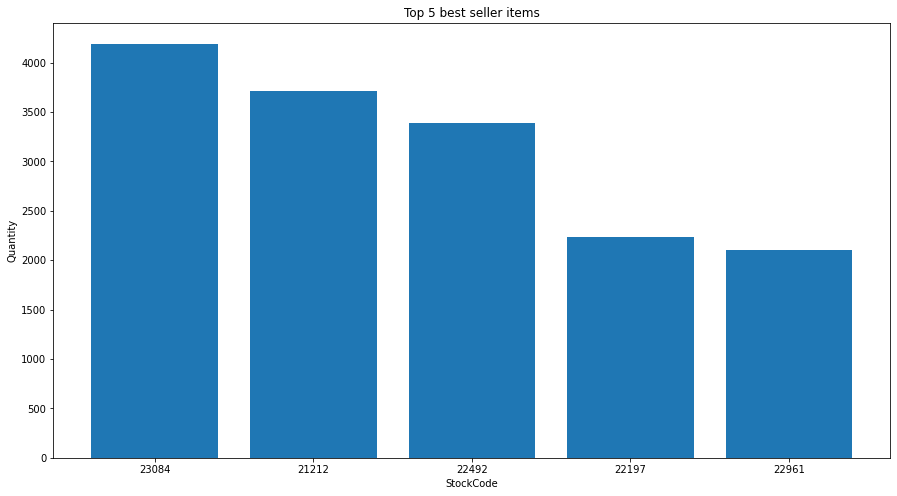

In [242]:
plt.figure(figsize=(15,8))
plt.bar(best_seller.StockCode.astype('string'), best_seller.Quantity)
plt.title('Top 5 best seller items')
plt.xlabel('StockCode')
plt.ylabel('Quantity')